# Model Training

In [1]:
# Import our dependencies
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Keras Specific Dependencies

In [2]:
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPool2D, Flatten

2023-04-17 15:11:25.349207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading, Checking, and Splitting our Prepocessed Data

In [3]:
# Load the cleaned and reduced dataframe
data = pd.read_csv("resources/data_reduced.csv", header=0, delimiter=",")
data.head()

,0,1,2,3,4,5,6,7,8,9,...,2296,2297,2298,2299,2300,2301,2302,2303,Labels,Emotions
0,59,71,89,118,139,160,183,222,212,148,...,0,0,0,0,0,0,1,0,1,Sad
1,90,97,105,42,41,41,37,40,36,55,...,42,48,83,107,105,77,51,32,1,Sad
2,219,221,222,224,225,226,227,229,230,231,...,17,8,3,31,46,38,59,74,1,Sad
3,51,51,53,50,47,44,41,40,37,37,...,26,59,65,66,64,62,60,56,0,Happy
4,91,118,124,101,97,130,149,147,144,137,...,202,210,202,120,106,106,101,94,0,Happy


In [4]:
# Split our preprocessed data into our features and target arrays
X = data.drop(['Labels', 'Emotions'],1).values
y = data['Labels'].values

# Verify the shape of our features (X) dataset and labels (y) datasets, ensuring the images are flattened (48 x 48 = 2304)
print("Image Data Shape:", X.shape)
print("Image Labels Shape:", y.shape)

Image Data Shape: (10252, 2304)
Image Labels Shape: (10252,)


/Users/terryschoch/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


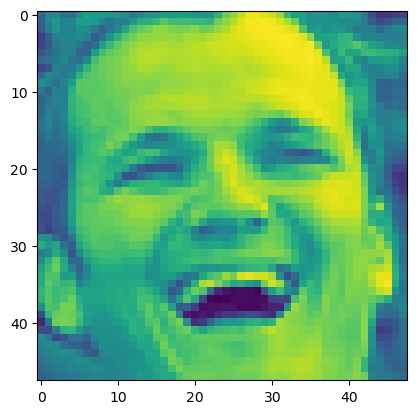

In [5]:
# Image Check: Create a copy of our data_cleaned dataframe with just the image features and convert a row to an array and resize to a 3 dimensional image in order to display via plt.show function
image_data_df = data.copy()
image_data_df.drop(image_data_df.columns[[2304, 2305]], axis=1, inplace=True)
arr = image_data_df.iloc[4].to_numpy()
arr = np.resize(arr, (48, 48))
plt.imshow(arr)
plt.show()

In [6]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    random_state=1,
                                                    stratify=y)

# Check the shape of our split data
print("Training Data Info")
print("Training Data Shape:", X_train.shape)
print("Training Data Shape:", y_train.shape)

print("Test Data Info")
print("Training Data Shape:", X_test.shape)
print("Training Data Shape:", y_test.shape)

Training Data Info
Training Data Shape: (7689, 2304)
Training Data Shape: (7689,)
Test Data Info
Training Data Shape: (2563, 2304)
Training Data Shape: (2563,)


### Scaling and Normalization 
**We use Sklearn's MinMaxScaler to normalize our data between 0 and 1**

In [7]:
# Normalize the training data to be between 0 and 1
scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### One-Hot Encoding

**We need to one-hot encode our integer labels using the `to_categorical` helper function**

In [8]:
# Our Training and Testing labels are integer encoded from 0 to 1. Look at the first 20 training labels.
y_train[:20]

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1])

In [9]:
# We need to convert our target labels (expected values) to categorical data
face_classes = 2
y_train = to_categorical(y_train, face_classes)
y_test = to_categorical(y_test, face_classes)
# Our first row label [0] of `0` is one-hot encoded as `1,0`
y_train[0]

array([1., 0.], dtype=float32)

## Building our Model

**In this example, we are going to build a Deep Multi-Layer Perceptron model with 3 hidden layers.**

In [10]:
# Create an empty sequential model
model = Sequential()

2023-04-17 15:11:37.191174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Add the first layer where the input dimensions are the 784 pixel values
# We can also choose our activation function. `relu` is a common
model.add(Dense(units=400, input_dim=2304, activation="relu"))

# Add a second hidden layer
model.add(Dense(units=200, activation="relu"))

# Add a third hidden layer
model.add(Dense(units=50, activation="relu"))

# Add our final output layer where the number of nodes 
# corresponds to the number of y labels
model.add(Dense(face_classes, activation="softmax"))

# We can summarize our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               922000    
                                                                 
 dense_1 (Dense)             (None, 200)               80200     
                                                                 
 dense_2 (Dense)             (None, 50)                10050     
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 1,012,352
Trainable params: 1,012,352
Non-trainable params: 0
_________________________________________________________________


## Compile and Train our Model

Now that we have our model architecture defined, we must compile the model using a loss function and optimizer. We can also specify additional training metrics such as accuracy.

In [12]:
# Use categorical crossentropy for categorical data and mean squared error for regression
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [13]:
# Fit (train) the model
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          steps_per_epoch=100, epochs=75, shuffle=True)

model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          steps_per_epoch=300, epochs=25, shuffle=True)

Epoch 1/75
100/100 [==============================] - 3s 19ms/step - loss: 0.7528 - accuracy: 0.5507 - val_loss: 0.6488 - val_accuracy: 0.6313
Epoch 2/75
100/100 [==============================] - 2s 18ms/step - loss: 0.6473 - accuracy: 0.6317 - val_loss: 0.6198 - val_accuracy: 0.6734
Epoch 3/75
100/100 [==============================] - 2s 20ms/step - loss: 0.6172 - accuracy: 0.6650 - val_loss: 0.6085 - val_accuracy: 0.6695
Epoch 4/75
100/100 [==============================] - 2s 19ms/step - loss: 0.5969 - accuracy: 0.6853 - val_loss: 0.6002 - val_accuracy: 0.6894
Epoch 5/75
100/100 [==============================] - 2s 19ms/step - loss: 0.5891 - accuracy: 0.6898 - val_loss: 0.6077 - val_accuracy: 0.6750
Epoch 6/75
100/100 [==============================] - 2s 18ms/step - loss: 0.5893 - accuracy: 0.6955 - val_loss: 0.6310 - val_accuracy: 0.6325
Epoch 7/75
100/100 [==============================] - 2s 19ms/step - loss: 0.5686 - accuracy: 0.7054 - val_loss: 0.5804 - val_accuracy: 0.7004

Epoch 58/75
100/100 [==============================] - 2s 19ms/step - loss: 0.3117 - accuracy: 0.8597 - val_loss: 0.7362 - val_accuracy: 0.7023
Epoch 59/75
100/100 [==============================] - 2s 19ms/step - loss: 0.3221 - accuracy: 0.8537 - val_loss: 0.7912 - val_accuracy: 0.6957
Epoch 60/75
100/100 [==============================] - 2s 18ms/step - loss: 0.3096 - accuracy: 0.8586 - val_loss: 0.7204 - val_accuracy: 0.7078
Epoch 61/75
100/100 [==============================] - 2s 19ms/step - loss: 0.3041 - accuracy: 0.8660 - val_loss: 0.7477 - val_accuracy: 0.6918
Epoch 62/75
100/100 [==============================] - 2s 21ms/step - loss: 0.3018 - accuracy: 0.8658 - val_loss: 0.7787 - val_accuracy: 0.7163
Epoch 63/75
100/100 [==============================] - 2s 21ms/step - loss: 0.3105 - accuracy: 0.8632 - val_loss: 0.7653 - val_accuracy: 0.7113
Epoch 64/75
100/100 [==============================] - 2s 21ms/step - loss: 0.3242 - accuracy: 0.8520 - val_loss: 0.7375 - val_accuracy:

In [14]:
# Save the model
model.save("models/data_trained.h5")

## Evaluating the Model

We use our testing data to validate our model. This is how we determine the validity of our model (i.e. the ability to predict new and previously unseen data points)

In [15]:
# Load our pre-trained and saved model
model = keras.models.load_model('models/data_trained.h5')

In [16]:
# Evaluate the model using the training data 
model_loss, model_accuracy = model.evaluate(X_test, y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

81/81 - 0s - loss: 0.8645 - accuracy: 0.7015 - 394ms/epoch - 5ms/step
Loss: 0.8645302653312683, Accuracy: 0.701521635055542


## Making Predictions

We can use our trained model to make predictions using `model.predict`

In [17]:
# Define a function for predictions and labelling finding "Happy" or "Sad" 
def happy_or_sad(x):
    predictions = x.predict(test)
    score = np.argmax(predictions)
    test_img = test.reshape(48, 48)
    if score == 1:        
        return f"Prediction: {predictions} \nImage Emotion is: Sad"
    return f"Prediction: {predictions} \nImage Emotion is: Happy"

In [20]:
# Grab just one data point to test with
test = np.expand_dims(X_train[3], axis=0)
test.shape

(1, 2304)

1/1 [==============================] - 0s 27ms/step
Prediction: [[9.9998665e-01 1.3381101e-05]] 
Image Emotion is: Happy


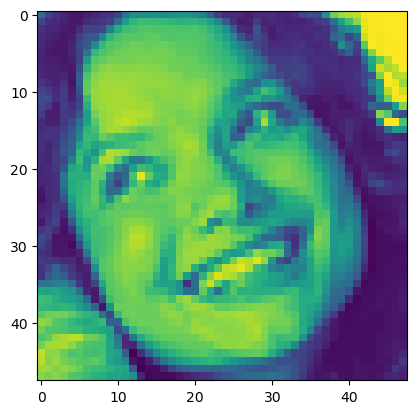

In [21]:
# Call our function to make a prediction on our test data point
print(happy_or_sad(model))

test_img = test.reshape(48, 48)
plt.imshow(test_img)

### Using Images outside our Dataset

Building an image scaler to pre-process and predict an image from the internet

In [22]:
# Import necessary libraries to capture image url and process
import urllib3 as urllib
import requests
import io
import PIL
import cv2

# Define function to capture, scale and process image
def image_scaler(x):
    '''x = image url'''
    # Request, read and open the image file and check it's dimensions
    response = requests.get(x)
    image_bytes = io.BytesIO(response.content)
    img = PIL.Image.open(image_bytes)
    img.show()
    print(f"Original Dimensions: {img.size}")
    # Resize the original file to our desired 48x48, confirm and save
    img_resized = img.resize((48, 48))
    img_resized.save('resources/internet_image_test.png')
    print(f"Resized Dimensions: {img_resized.size}") 
    
    # Read the saved resized image, convert to 1d grayscale and call our predict function
    test_img = cv2.imread('resources/internet_image_test.png')
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    test = test_img.flatten().reshape(-1, 48*48)     
    return print (f"{happy_or_sad(model)} \n{plt.imshow(test_img)}")

Original Dimensions: (762, 800)
Resized Dimensions: (48, 48)
1/1 [==============================] - 0s 89ms/step
Prediction: [[9.9998665e-01 1.3381101e-05]] 
Image Emotion is: Happy 
AxesImage(80,52.8;496x369.6)


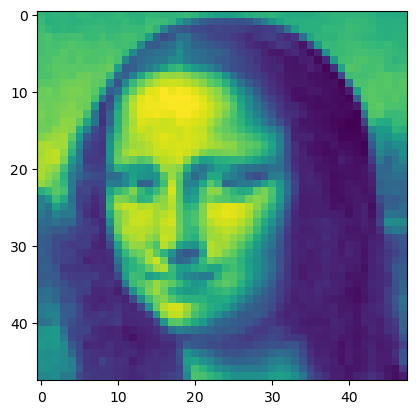

In [23]:
image_scaler('https://www.exploringart.co/wp-content/uploads/2021/09/Mona-Lisa_7.jpg')